# <center> Sentiment Analysis using Twitter Hashtag</center>

## Team
**G2 Alexanderia**
1. **Ayham Ramdan**
2. **Nourhan Selim**



## Motivation
I was motivated to implement this project as i wanted to know how my hashtags where handeled by the 
community. The main question to know this was " Is the community using this hashtag when they relate to 
happy thoughts / opinnions or when they are not happy "

## DataSet
 we create a custom dataset for each user of the application as they input the hashtag they desire to know more about. 
 hence, we use "tweepy" to get a table ( Dataframe ) with 2 columns of the hashtag (input) and the text of the tweets then we do some process to make the dataset contains 3 columns  
 ( Hashtag | tweets(text) | Sentiment( positive , negative, neutral) )  



## proceduers

### 1-Define libraries

In [1]:
# import modules
import pandas as pd
import tweepy
import numpy as np
from transformers import pipeline
from tqdm import tqdm
import re

In [2]:
# import libraries for Dash
import dash
import dash_bootstrap_components as dbc
import pandas as pd
import plotly.express as px
from dash import Input, Output, dcc, html,State

### 2-Define Functions

#### Scraping
steps needed :
1. keys , secret keys that are needed to access the twitter API 
2. perform the the authentication and create a link 
3. set the required hashtag = words and the lang = ar (language of the hashtag) and the number of tweets 
4. then get a list of all twitts containing the word 
5. creating the Datafram ( HASHTAG |  Tweets ( TEXT ) )

In [3]:
# function to perform data extraction
def scrape(words="كأس_العرب#", numtweet=900):
# Creating DataFrame using pandas
    consumer_key = "xxxxxxxxxxxxxxxxxxxx"
    consumer_secret = "xxxxxxxxxxxxxxxxxxxx"
    access_key = "xxxxxxxxxxxxxxxxxxxx"
    access_secret = "xxxxxxxxxxxxxxxxxxxx"
    auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
    auth.set_access_token(access_key, access_secret)
    api = tweepy.API(auth,wait_on_rate_limit = True)
    db = pd.DataFrame(columns=['text', 'hashtags'])

# We are using .Cursor() to search through twitter for the required tweets.
# The number of tweets can be restricted using .items(number of tweets)
    tweets = tweepy.Cursor(api.search_tweets, q=words, lang="ar", tweet_mode='extended').items(numtweet)

# .Cursor() returns an iterable object. Each item in
# the iterator has various attributes that you can access to
# get information about each tweet
    list_tweets = [tweet for tweet in tweets]

# we will iterate over each tweet in the list for extracting information about each tweet
    for tweet in list_tweets:
        hashtags = tweet.entities['hashtags']
# Retweets can be distinguished by a retweeted_status attribute,
# in case it is an invalid reference, except block will be executed
        try:
            text = tweet.retweeted_status.full_text
        except AttributeError:
            text = tweet.full_text
        hashtext = list()

        for j in range(0, len(hashtags)):
            # print(hashtags[j]['text']+" "+str(len(hashtags[j]['text'])))
            hash = words.split("#")[0]
            # print(hash)
            if (hashtags[j]['text']== hash):
                    hashtag = hash
                    # print(hashtag)
                    hashtext.append(hashtag)
                    ith_tweet = [text, hashtext]
                    db.loc[len(db)] = ith_tweet

# Here we are appending all the extracted information in the DataFrame

    filename = 'scraped_tweets.csv'
    # we will save our database as a CSV file.
    db.to_csv(filename)
    return db

#### Sentement Annalysis 
1. we get our pipline ready which contains ( tokkeninzation  , vectorization , word embedding ,...) and model 
2. get row by row from the Dataset from the previous function
3. some preprocessing ( removing the links ) on the tweets ( text ) 
4. then input it to the model "araber/camelbert"
5. the output of the model is a list of dictionaries which we will get the label and place it in a new dataframe
6. create a new dataframe ( HASHTAG | Tweets | Sentiment ) 

In [4]:
def sent_ann(df):
  sa = pipeline('text-classification', model='CAMeL-Lab/bert-base-arabic-camelbert-da-sentiment')
  df_new = []
  for index, row in tqdm(df.iterrows()):
    # print(row)
    sentence = row["text"]
    sentence=re.sub(r'http\S+', '', sentence)
    # print(sentence)
    output = sa(sentence)
    row['sentement']= output[0].get('label')
    df_new.append(row)
  return df_new
  

#### Main Function 
sent all the parameters needed to start the twitter API and get the results back for more preprocessing 
before placing it in the bar plot 

In [5]:
def create_dataset(words="كأس_العرب#", numtweet=900):
    
    print('Scrappting Started!')
    df=scrape(words, numtweet)
    print('Scrappting done!')
    df_new = pd.DataFrame(sent_ann(df))
    df_new.to_csv(words+"_sentement.csv")
    value_count=pd.DataFrame(df_new.sentement.value_counts())
    total=value_count['sentement'].sum()
    x=[]
    for i in range(3):
        x.append(np.round((value_count.iloc[i,0]/total)*100,2))
    value_count['percentage']=x
    return value_count


# Dash

In [6]:
app = dash.Dash(external_stylesheets=[dbc.themes.SUPERHERO])

In [7]:
def bar_chart(data_frame):
    fig4=px.bar(data_frame, x=data_frame.index, y='percentage',
               template='seaborn',text='percentage',
               labels= {'index': "sentement",'percentage':'percentage'},
                color=data_frame.index,
               color_discrete_map={
                                    'negative': 'red',
                                    'neutral': 'blue',
                                    'positive':'green'
    })
    fig4.update_traces(texttemplate='%{text} %', textposition='inside',textfont_size=20)
    fig4.update_layout(yaxis = dict(tickfont = dict(size=14)),height=500)
    return fig4


In [8]:
@app.callback(
#     Output("loading", "children"),
    Output('barplot','figure'),
     
   
    Input('button', 'n_clicks'),
    State("hash",'value'),
    
)


def update_fig(submit,search_word):
    value_count=create_dataset(words=search_word, numtweet=900)
    
    return bar_chart(value_count)


In [9]:
controls = dbc.Card(
    [
        html.Div(
            [
                dbc.Label("Hashtag",size="lg"),
                html.Br(),
                dbc.FormText("Enter Twitter HashTag to search for"),
                dbc.Input(id="hash",type='text',style={'color':'white'}), 
                dbc.Button("submit", id="button", className="me-2", n_clicks=0,size="lg"),
                
            ]
        ),
            ],
    body=True,
)

In [10]:
app.layout = dbc.Container(
    [
        html.Br(),
        html.H1("Sentiment Analysis using Twitter Hashtag" , style={'textAlign': 'center'}),
        html.Hr(),
        dbc.Row(
            [
                dbc.Col(controls, md=4),
#                 dbc.Col(dcc.Loading(id = "loading",children=dcc.Graph(id='barplot',figure={}))),
                dbc.Col(dcc.Graph(id='barplot',figure={}))
            ],
            align="center",
        ),
    ],
    fluid=True,
)

In [ ]:
app.run_server()

Dash is running on http://127.0.0.1:8050/

 * Serving Flask app '__main__' (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off


 * Running on http://127.0.0.1:8050/ (Press CTRL+C to quit)
127.0.0.1 - - [12/Dec/2021 19:30:35] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [12/Dec/2021 19:30:36] "GET /_dash-layout HTTP/1.1" 200 -
127.0.0.1 - - [12/Dec/2021 19:30:36] "GET /_dash-dependencies HTTP/1.1" 200 -
127.0.0.1 - - [12/Dec/2021 19:30:36] "GET /_dash-component-suites/dash/deps/polyfill@7.v2_0_0m1632235559.12.1.min.js HTTP/1.1" 200 -
127.0.0.1 - - [12/Dec/2021 19:30:36] "GET /_dash-component-suites/dash/deps/react-dom@16.v2_0_0m1632235559.14.0.min.js HTTP/1.1" 200 -
127.0.0.1 - - [12/Dec/2021 19:30:36] "GET /_dash-component-suites/dash/deps/react@16.v2_0_0m1632235559.14.0.min.js HTTP/1.1" 200 -
127.0.0.1 - - [12/Dec/2021 19:30:36] "GET /_dash-component-suites/dash/deps/prop-types@15.v2_0_0m1632235559.7.2.min.js HTTP/1.1" 200 -
127.0.0.1 - - [12/Dec/2021 19:30:36] "GET /_dash-component-suites/dash/dash_table/bundle.v5_0_0m1632235559.js HTTP/1.1" 200 -
127.0.0.1 - - [12/Dec/2021 19:30:36] "GET /_dash-component-suites/dash

Scrappting Started!


127.0.0.1 - - [12/Dec/2021 19:30:37] "GET /_dash-component-suites/dash/dcc/async-graph.js HTTP/1.1" 304 -
127.0.0.1 - - [12/Dec/2021 19:30:37] "GET /_dash-component-suites/dash/dcc/async-plotlyjs.js HTTP/1.1" 304 -


Exception on /_dash-update-component [POST]
Traceback (most recent call last):
  File "C:\Users\nourh\anaconda3\envs\noura\lib\site-packages\flask\app.py", line 2073, in wsgi_app
    response = self.full_dispatch_request()
  File "C:\Users\nourh\anaconda3\envs\noura\lib\site-packages\flask\app.py", line 1518, in full_dispatch_request
    rv = self.handle_user_exception(e)
  File "C:\Users\nourh\anaconda3\envs\noura\lib\site-packages\flask\app.py", line 1516, in full_dispatch_request
    rv = self.dispatch_request()
  File "C:\Users\nourh\anaconda3\envs\noura\lib\site-packages\flask\app.py", line 1502, in dispatch_request
    return self.ensure_sync(self.view_functions[rule.endpoint])(**req.view_args)
  File "C:\Users\nourh\anaconda3\envs\noura\lib\site-packages\dash\dash.py", line 1336, in dispatch
    response.set_data(func(*args, outputs_list=outputs_list))
  File "C:\Users\nourh\anaconda3\envs\noura\lib\site-packages\dash\_callback.py", line 151, in add_context
    output_value = fu

127.0.0.1 - - [12/Dec/2021 19:30:40] "POST /_dash-update-component HTTP/1.1" 500 -


Scrappting Started!
Scrappting done!


247it [00:36,  6.72it/s]
127.0.0.1 - - [12/Dec/2021 19:33:40] "POST /_dash-update-component HTTP/1.1" 200 -


## Conclusion

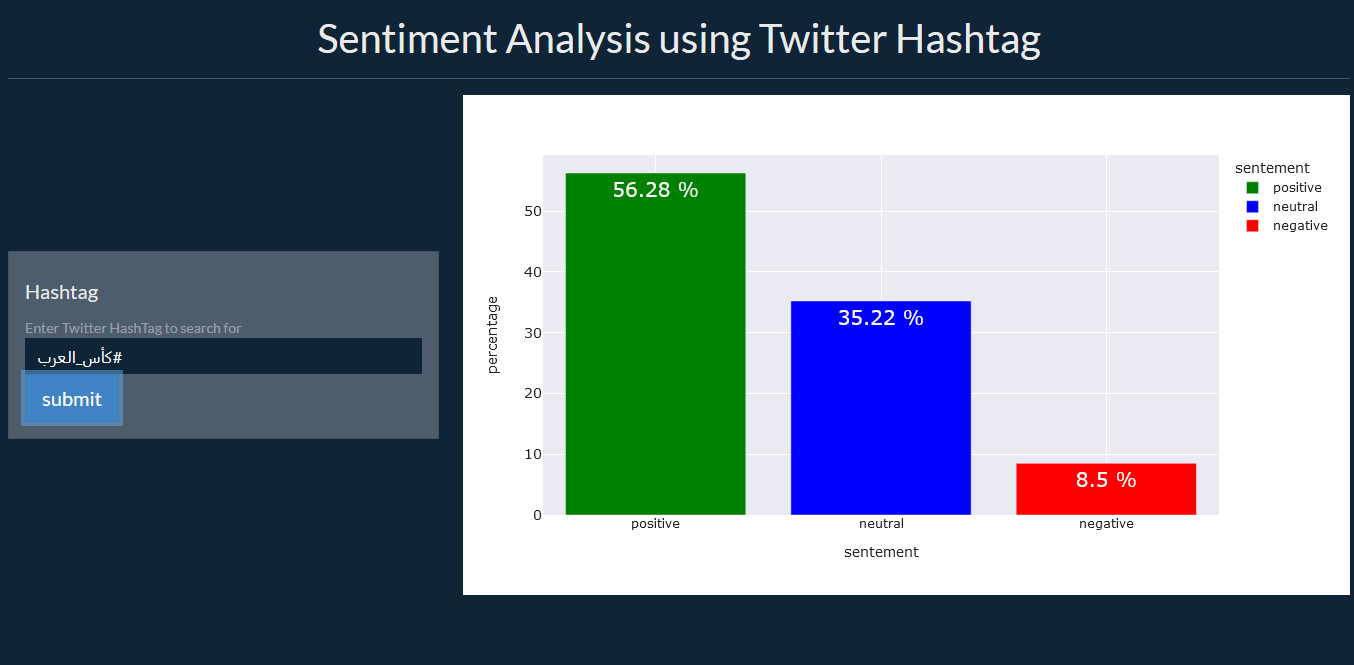